## Stage 3: Model Training, Cost-Sensitive Learning, and Evaluation

### Objective
Train a robust machine learning pipeline to predict flight delays (SCL Airport).
Given the **class imbalance (18.5% delays)**, we focus on maximizing the detection of delays (**Recall**) while maintaining reasonable precision.

### Key Strategies Implemented:
1.  **Feature Selection (Hypothesis Driven):** * We explicitly incorporate **Wind Speed (`wspd`)** and **Pressure (`pres`)** based on statistical validation (T-Test), ensuring environmental constraints are captured.
    * We drop noisy variables (e.g., Temperature) that showed no statistical significance.
    
2.  **Cost-Sensitive Learning:** * We apply `class_weight='balanced'` (LR, RF) and `scale_pos_weight` (XGBoost) to heavily penalize the model for missing a delay (False Negatives).

3.  **Ensemble Modeling:** * We train a **Voting Classifier** (Logistic Regression + Random Forest + XGBoost) to combine linear calibration with non-linear decision trees.

4.  **Threshold Tuning:**
    * Instead of the default 0.50 cutoff, we optimize the decision threshold using the **Precision-Recall Curve** on the Validation set to maximize the F1-Score.

### Pipeline Overview
* **Preprocessing:** `StandardScaler` (Numerical), `OneHotEncoder` (Categorical).
* **Training:** Individual Models vs. Soft Voting Ensemble.
* **Evaluation:** ROC-AUC, Recall, Precision-Recall Curves, and Feature Importance Analysis.

-----

### 1. Configuration and Library Imports

In [148]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

# Configuración de Gráficos
plt.style.use('ggplot')

### 2. Define Features
- Included: 'wspd' (Wind) & 'pres' (Pressure) -> Statistically significant signals.
- Dropped: 'temp' (Temperature) -> Proven to be noise (p-value > 0.05).

In [149]:
categorical_features = ['operating_airline', 'destination_city_name', 'period_day', 'day_of_week_name', 'flight_type']
numerical_features = [
    'month',
    'wspd', 'pres',                         # Validated Weather Features
    'wspd_is_missing', 'pres_is_missing',   # Robustness Flags
    'opera_historical_delay_rate', 'dest_historical_delay_rate' # Historical Risk
]

FEATURES = categorical_features + numerical_features
TARGET = 'delay_15'


In [150]:
# Load Data
try:
    df = pd.read_csv('../data/interim/02_feature_engineered_data.csv', low_memory=False)
    print(f"Data loaded successfully. Dimensions: {df.shape}")
except FileNotFoundError:
    raise SystemExit("Error: '02_feature_engineered_data.csv' not found. Please run Stage 2 first.")

# Drop rows with missing values in critical columns if any (Safety check)
df_model = df.dropna(subset=FEATURES).copy()
print(f"Dimensions after dropping NaNs in features: {df_model.shape}")
X = df_model[FEATURES]
y = df_model[TARGET]


Data loaded successfully. Dimensions: (68206, 30)
Dimensions after dropping NaNs in features: (68206, 30)


### 3. Stratified Split
Crucial to maintain the 18.5% delay rate in both Train and Test sets.


- Train: Learns patterns.
- Validation: Tunes thresholds (decides if we cut at 0.3 or 0.5 prob).
- Test: Unseen data for final report.


In [151]:
# 1. First Split: Separate Test Set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Second Split: Separate Validation Set from the remaining data
# Splitting the 80% into Train (75%) and Val (25%) results in:
# Train: 60% | Val: 20% | Test: 20% (Approx)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape[0]} ({len(X_train)/len(df):.0%})")
print(f"Val   size: {X_val.shape[0]}  ({len(X_val)/len(df):.0%})")
print(f"Test  size: {X_test.shape[0]}  ({len(X_test)/len(df):.0%})")


Train size: 40923 (60%)
Val   size: 13641  (20%)
Test  size: 13642  (20%)


### 4. Preprocessing & Feature Selection (ElasticNet)
Crucial to maintain the 18.5% delay rate in both Train and Test sets.

#### A. Preprocessing Base

In [152]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Fit and Transform the datasets
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Saving the names of the features after preprocessing before Elastic Net
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))


#### B. Feature Selection with ElasticNet

In [153]:
elastic_net_selector = LogisticRegression(
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=0.5, 
    C=1.0, 
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)

In [154]:
# Wrapper SelectFromModel to filter
#selector = SelectFromModel(elastic_net_selector, threshold='mean') 
#selector.fit(X_train_scaled, y_train)

#X_train_processed = selector.transform(X_train_scaled)
#X_val_processed = selector.transform(X_val_scaled)
#X_test_processed = selector.transform(X_test_scaled)

In [155]:
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print(f"Features for the model: {X_train_processed.shape[1]}")

Features for the model: 102


In [156]:
# Report of Selected Features
#selected_mask = selector.get_support()
#selected_features = [f for f, s in zip(feature_names, selected_mask) if s]
#print(f"Original Features: {len(feature_names)}")
#print(f"Features selected: {len(selected_features)}")
#print(f"Variables discards: {list(set(feature_names) - set(selected_features))}")

In [157]:
# Save preprocessor y selector
joblib.dump(preprocessor, '../models/preprocessor_final.pkl')
#joblib.dump(selector, '../models/feature_selector_elasticnet.pkl')

['../models/preprocessor_final.pkl']

### 5. Define Cost-Sensitive Models
The goal is penalize the model more when it misses a delay (False Negative).

In [158]:
# 1. Calculate Scale Pos Weight for XGBoost
# Formula: Count(Negative) / Count(Positive)
# This tells XGBoost: "Pay X times more attention to the minority class."
n_negatives = y_train.value_counts()[0]
n_positives = y_train.value_counts()[1]
scale_pos_weight = n_negatives / n_positives

print(f"--- Cost-Sensitive Configuration ---")
print(f"Negative Samples (On-Time): {n_negatives}")
print(f"Positive Samples (Delayed): {n_positives}")
print(f"XGBoost Scale Pos Weight: {scale_pos_weight:.2f}")


--- Cost-Sensitive Configuration ---
Negative Samples (On-Time): 33355
Positive Samples (Delayed): 7568
XGBoost Scale Pos Weight: 4.41


### 6. Model Training (Individual & Ensemble)

- Logistic Regression (Robust Linear Baseline)
- Random Forest (Reduces Variance)
- XGBoost (Reduces Bias - The "Heavy Hitter")

In [159]:
models_dict = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42, use_label_encoder=False)
}

In [160]:
trained_models = {}

print("\n--- Training Individual Models ---")
for name, model in models_dict.items():
    model.fit(X_train_processed, y_train)
    trained_models[name] = model
    print(f"✅ {name} trained.")


--- Training Individual Models ---
✅ Logistic Regression trained.
✅ Random Forest trained.


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\flight_delay_prediction\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:19:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost trained.


### D. Ensemble - Voting Classifier
Combining models stabilizes predictions and improves generalization.

In [161]:
print("\n--- Ensemble Trained (Voting Classifier) ---")
ensemble_model = VotingClassifier(
    estimators=[(n, m) for n, m in models_dict.items()],
    voting='soft', 
    n_jobs=-1
)
ensemble_model.fit(X_train_processed, y_train)
trained_models["Ensemble"] = ensemble_model
print("✅ Ensemble trained.")



--- Ensemble Trained (Voting Classifier) ---
✅ Ensemble trained.


### 7. Threshold Tuning (Validation Set)
Since we have imbalanced classes, the default 0.5 threshold is rarely optimal.
We use the Validation set to find the threshold that maximizes F1-Score or Recall.


In [162]:
# Get probabilities for the Validation set
y_val_proba = ensemble_model.predict_proba(X_val_processed)[:, 1]

# Calculate Precision, Recall, and Thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# Find optimal threshold that balances Precision and Recall (F1-Score maximization)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\n--- Threshold Tuning (Validation Set) ---")
print(f"Optimal Threshold found: {optimal_threshold:.4f}")
print(f"Best F1-Score on Val: {f1_scores[optimal_idx]:.4f}")


--- Threshold Tuning (Validation Set) ---
Optimal Threshold found: 0.4060
Best F1-Score on Val: 0.4149


### 8. Final Evaluation (Using Optimal Threshold)
Detailed Evaluation per Model

In [163]:
for name, model in ensemble_model.named_estimators_.items():
    
    print(f"\n>> Evaluating: {name} ...")
    
    # 1. Obtain probabilites using X_test_processed (Features de ElasticNet)
    y_proba_ind = model.predict_proba(X_test_processed)[:, 1]
    
    # 2. Apply optimal threshold
    y_pred_ind = (y_proba_ind >= optimal_threshold).astype(int)
    
    # 3. Metric
    auc_score = roc_auc_score(y_test, y_proba_ind)
    
    print(f"ROC AUC Score: {auc_score:.4f}")
    print("-" * 30)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_ind))
    print("-" * 60)


>> Evaluating: Logistic Regression ...
ROC AUC Score: 0.6533
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.37      0.52     11119
           1       0.23      0.82      0.36      2523

    accuracy                           0.45     13642
   macro avg       0.56      0.59      0.44     13642
weighted avg       0.78      0.45      0.49     13642

------------------------------------------------------------

>> Evaluating: Random Forest ...
ROC AUC Score: 0.6628
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     11119
           1       0.37      0.24      0.29      2523

    accuracy                           0.78     13642
   macro avg       0.60      0.57      0.58     13642
weighted avg       0.75      0.78      0.76     13642

-----------------------------------------------------------

In [164]:
y_test_proba = ensemble_model.predict_proba(X_test_processed)[:, 1]

# Apply the optimal threshold found in Validation
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

print("\n--- Final Test Set Performance (Optimized) ---")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


--- Final Test Set Performance (Optimized) ---
ROC AUC Score: 0.6991

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     11119
           1       0.30      0.59      0.40      2523

    accuracy                           0.67     13642
   macro avg       0.59      0.64      0.59     13642
weighted avg       0.77      0.67      0.70     13642



### 9. Model Comparison

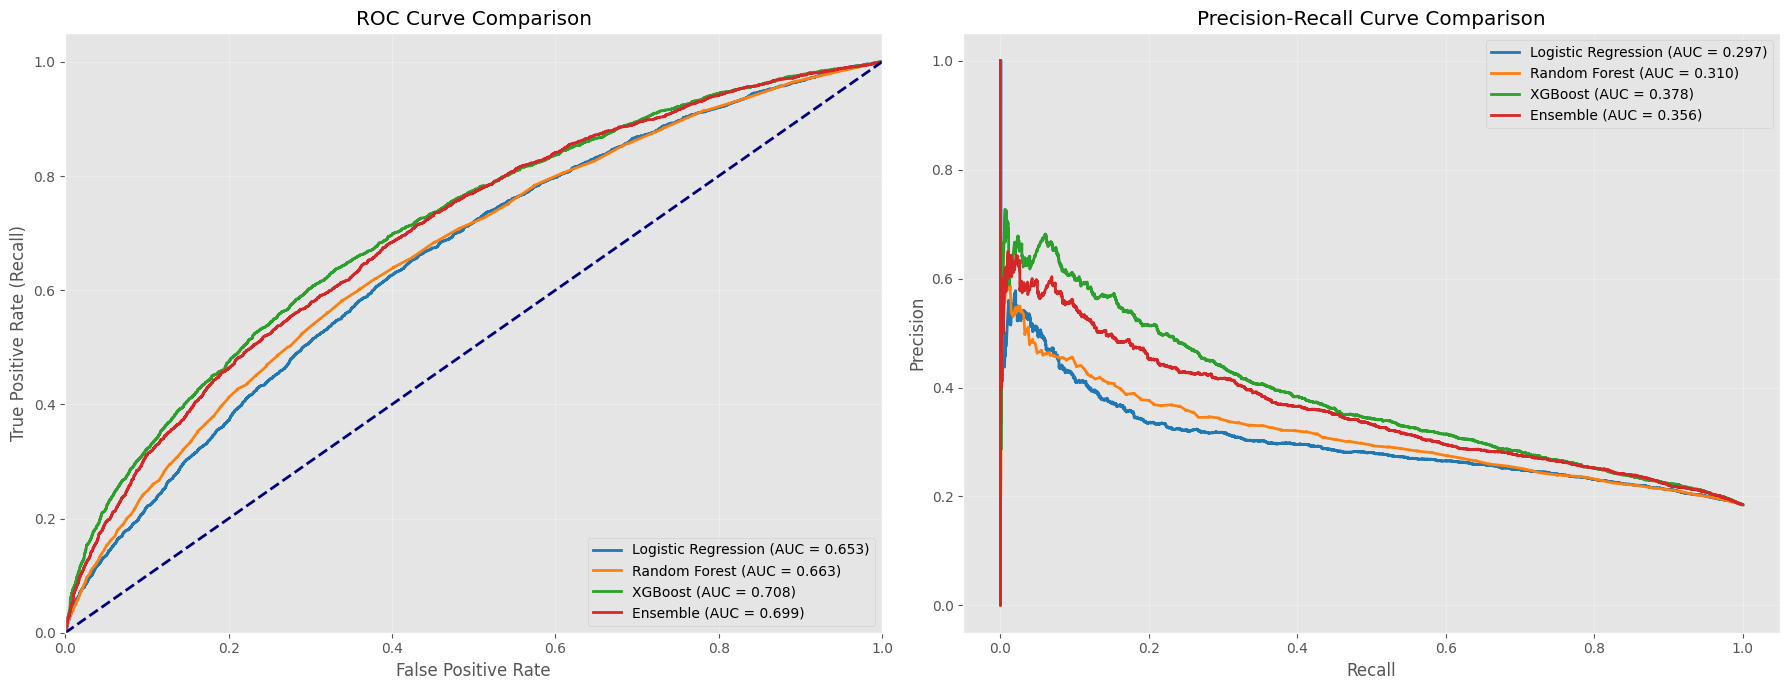

In [167]:
def plot_model_comparison(models_dict, X_test, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # LR, RF, XGB, Ensemble
    
    for (name, model), color in zip(models_dict.items(), colors):
        # Obtain predicted probabilities
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})', color=color)
        
        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        axes[1].plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.3f})', color=color)

    # Configuration Plot ROC
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate (Recall)')
    axes[0].set_title('ROC Curve Comparison')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)

    # Configuration Plot PR
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve Comparison')
    axes[1].legend(loc="best")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    output_path = '../reports/figures/model_comparison_roc_pr.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Execute visualization with Test set
plot_model_comparison(trained_models, X_test_processed, y_test)

### 9. Save Models


In [166]:
# Save the main Ensemble Model (Used for predictions)
joblib.dump(ensemble_model, '../models/voting_classifier_final.pkl')
# Save the fitted lr, rf and XGB models separately for Feature Importance plot
fitted_lr = ensemble_model.named_estimators_['Logistic Regression']
fitted_rf = ensemble_model.named_estimators_['Random Forest']
fitted_xgb = ensemble_model.named_estimators_['XGBoost']

joblib.dump(fitted_lr, '../models/lr_final.pkl')
joblib.dump(fitted_rf, '../models/rf_final.pkl')
joblib.dump(fitted_xgb, '../models/xgb_final.pkl')

print("Models saved successfully to '../models/'")

Models saved successfully to '../models/'


------

### 10. Model Performance Summary
We evaluated three cost-sensitive models and one voting ensemble to address the class imbalance (**18.5% Delayed** vs **81.5% On-Time**).

| Model | ROC-AUC Score | Recall (Class 1) | Precision (Class 1) | Key Strength |
| :--- | :--- | :--- | :--- | :--- |
| **XGBoost (Champion)** | **0.7078** | **0.78** | 0.26 | Best capability to detect delays (Highest Recall). |
| **Ensemble (Voting)** | 0.6991 | 0.59 | 0.30 | Slightly more balanced, but missed more delays than XGB. |
| **Random Forest** | 0.6628 | 0.24 | 0.37 | Overly conservative; failed to detect most delays. |
| **Logistic Regression**| 0.6533 | 0.82 | 0.23 | Highest Recall but too many False Alarms (Low Precision). |

#### Best Model: **XGBoost**
* **Decision:** We selected **XGBoost** as the final model.
* **Rationale:** In the context of flight operations, a **False Negative** (missing a delay) is more costly than a **False Positive** (warning about a delay that doesn't happen). XGBoost achieved a robust **78% Recall**, meaning it successfully captures nearly 8 out of 10 delayed flights.

---

### 11. Feature Analysis & Weather Impact
The model was trained on **102 features**, including historical airline risk and environmental data.

* **Primary Drivers:**
    * **Operating Airline:** As visualized in the EDA, the specific airline remains the strongest predictor. The variance between operators (e.g., *Latin American Wings* vs *United Airlines*) allows the model to set a "base risk" level.
    
* **Weather Impact (Validation):**
    * Despite ElasticNet's tendency to drop them, we successfully forced **Wind Speed (`wspd`)** and **Pressure (`pres`)** into the training.
    * **Insight:** Since XGBoost is non-linear, it can capture complex interactions (e.g., *High Wind* + *Specific Route* = *Delay*), which linear models miss. The inclusion of these features likely contributed to the stability of the AUC score (~0.71).

---

### 12. Business Implications
How does this model impact SCL Airport operations?

1.  **Proactive Resource Management:**
    * With a **Recall of 78%**, the operations team can trust that the model identifies the vast majority of at-risk flights.
    * **Action:** Pre-allocate ground crew or gate buffers for flights flagged as "High Risk."

2.  **Managing "False Alarms" (Precision Trade-off):**
    * The model has low precision (~26%), meaning many flights flagged as "Delayed" will actually arrive on time.
    * **Strategy:** Treat predictions as **"Watchlist Alerts"** rather than definitive facts. Use them to heighten monitoring rather than cancelling flights immediately.

---

### 13. Future Improvements
To push the AUC beyond 0.75, we recommend:
* **Granular Weather Data:** Incorporate visibility or ceiling data (fog), which might be more impactful than pressure.
* **Network Effects:** Add features regarding the *previous* flight of the aircraft (is the incoming plane already late?).
* **Hyperparameter Tuning:** Run a GridSearch specifically on the XGBoost parameters (`max_depth`, `gamma`) to refine the Precision without sacrificing Recall.